<h1 style='text-align:center'> DS605 AIML Assignment 2 </h1>
<hr>
<h1 style='text-align:center'>  </h1>
<br>

- By Vedant .B. Marodkar \
- 12240990 \
- DSAI'26


---

# **`Abstract`**

Throughout this report, the details for development of a multilingual assistive model which aims at providing comprehensive support for visually impaired users, are discussed. The model integrates and alligns concepts of advanced image captioning, translation, and text-to-speech synthesis to offer descriptive and multilingual content in audio format. The workflow utilizes the **BLIP** model for image captioning, **IndicTrans2** for translation, and **gTTS** for speech synthesis.

---

# **`Methodology`**:

In this section, we will outline our approach for developing the multilingual assistive model. Our methodology involves several key steps:

- **Model Selection**:
  - **Image Captioning**: We select the **BLIP (Bootstrapped Language Image Pretraining)** model by **Salesforce** to generate descriptive captions from input images. This multimodal pre-trained on **MS COCO** dataset provides extensive results on image captioning tasks.
  - **Translation**: The **IndicTrans2** model is chosen for translating English captions into multiple Indian languages. Using this pre-trained translation model, we used for translating generated captions into Indic languages like Hindi, marathi and Gujarati.
  - **Speech Synthesis**: The **gTTS** library is used to generate audio files from the translated text for narration purpose. This is done by using the **Google Translate's** API for Text-To-Speech.

- **Inference**:
  - **Generating Captions**: Using the BLIP model, we generate captions from input images.
  - **Translating Captions**: The generated captions are passed to the IndicTrans2 model for translation into selected Indian languages.
  - **Narrating Descriptions**: The translated text is then converted into speech using the Whisper model.


# **`Inference`**:
## **Stage 1 : Generating Captions from image**:

- We begin by getting all of our required libraries, packages and dependecies.
- Installing IndicTransToolkit (earlier IndicTransTokenizer) in editable mode.

- It is recommended to **`restart the session`** after setting up the environment by executing the cell below.

In [1]:
# The GitHub repository was recently updated and also renamed from `IndicTransTokenizer` --> `IndicTransToolkit`
!git clone https://github.com/VarunGumma/IndicTransToolkit
%cd IndicTransToolkit
!python3 -m pip install --editable ./
%cd ..

Cloning into 'IndicTransToolkit'...
remote: Enumerating objects: 155, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 155 (delta 34), reused 45 (delta 30), pack-reused 95 (from 1)
Receiving objects: 100% (155/155), 3.88 MiB | 15.81 MiB/s, done.
Resolving deltas: 100% (62/62), done.
/content/IndicTransToolkit
Obtaining file:///content/IndicTransToolkit
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/VarunGumma/indic_nlp_library to /tmp/pip-install-tzfhz2s3/indic-nlp-library-it2_b22b023594c44d619ff32b00d050a754
  Running command git clone --filter=blob:none --quiet https://github.com/VarunGumma/indic_nlp_library /tmp/pip-install-tzfhz2s3/indic-nlp-library-it2_b22b023594c44d619ff32b00d050a754
  Resolved https://github.com/VarunGumma/indic_nlp_library to commit 601521e05ed0ed8f2165ac317a47d186e25b6f0d
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.

In [2]:
!pip install gtts
!pip install librosa IPython
!pip install datasets
!pip install torchaudio

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.3 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<1

## Importing required libraries

In [35]:
import torch
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration , MarianMTModel, MarianTokenizer
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, BitsAndBytesConfig, Pipeline
from transformers import VitsTokenizer, VitsModel, set_seed
from IndicTransToolkit import IndicProcessor
import matplotlib.pyplot as plt
import librosa
import pandas as pd
import numpy as np
import librosa.display
from IPython.display import Audio, display
from gtts import gTTS
import base64
from PIL import Image
import io
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="transformers")
warnings.filterwarnings("ignore")

## Importing model and preprocessor for stage 1

In [2]:
# Initialize BLIP for image captioning
blip_processor_stage1 = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
blip_model_stage1 = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large").to("cuda" if torch.cuda.is_available() else "cpu")


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/527 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

### Image captioning using BLIP

In [3]:
# BLIP Captioning
def generate_caption(image_path):
    # Open and prepare the image
    image = Image.open(image_path).convert("RGB")
    # Preprocess the image for the BLIP model
    text = "image of"
    inputs = blip_processor_stage1(image,text,  return_tensors="pt").to("cuda" if torch.cuda.is_available() else "cpu")
    # Generate caption with the BLIP model
    with torch.no_grad():
        generated_ids = blip_model_stage1.generate(**inputs)
    # Decode the generated ids into text
    caption = blip_processor_stage1.decode(generated_ids[0], skip_special_tokens=True)
    return caption


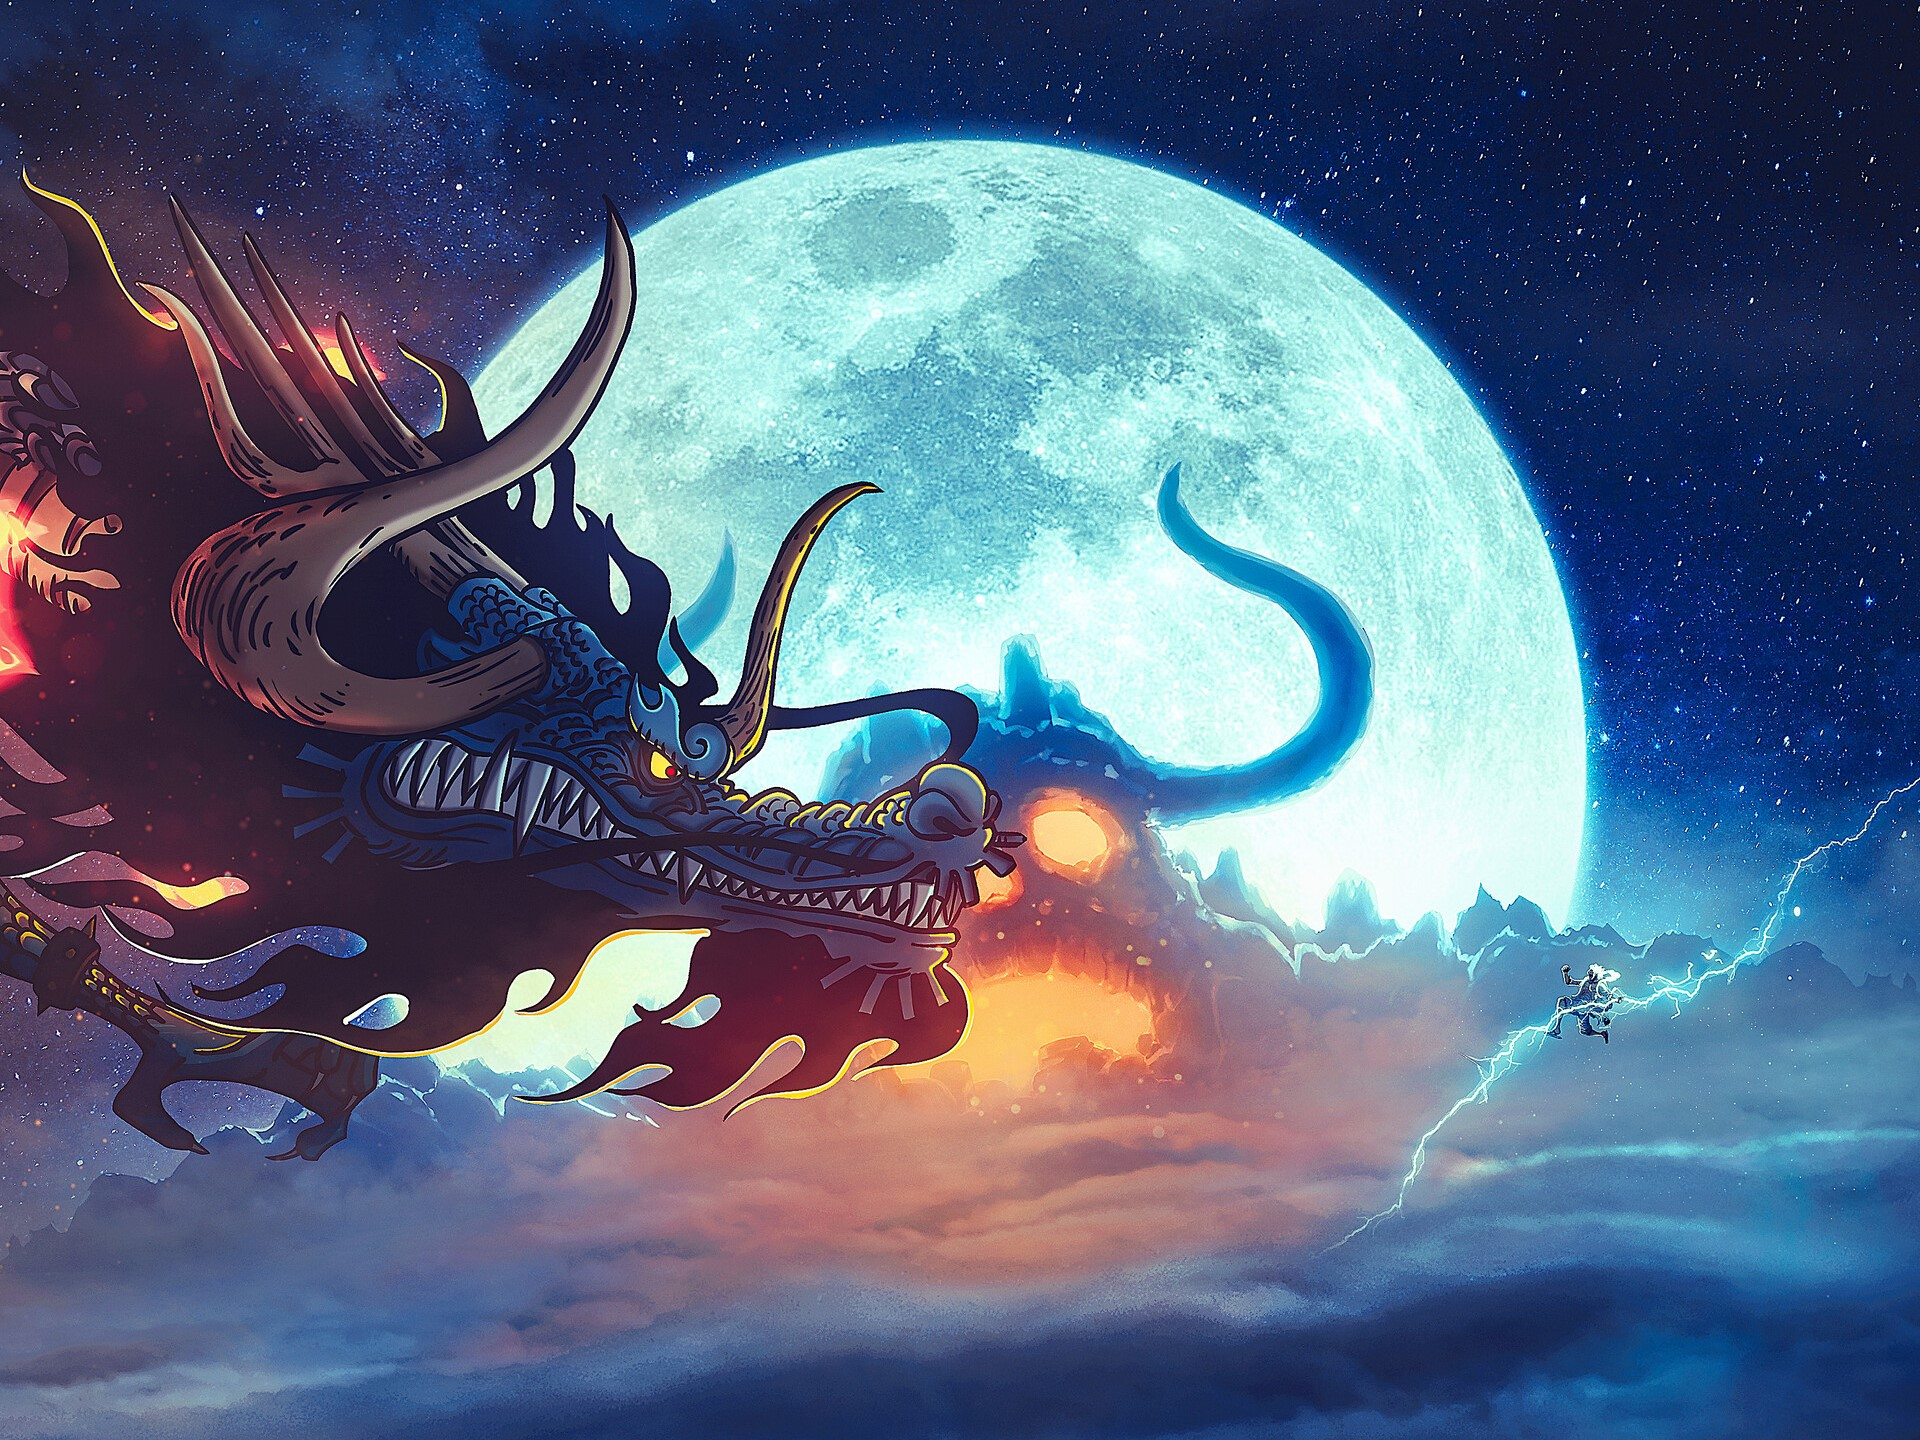

In [4]:
with open("1329456.jpeg", "rb") as img_file:
    base64_string = base64.b64encode(img_file.read()).decode('utf-8')

image_data = base64.b64decode(base64_string)
image = Image.open(io.BytesIO(image_data))

image_path = "/content/dry_run_image00.jpeg"
image.save(image_path)

# Demo Run
caption = generate_caption(image_path)
print(f"Generated Caption: {caption}")

Generated Caption: image of a dragon with a full moon in the background


Since, we are now able to successfully generate captions for our image with pretty good accuracy, now we move towards the stage 2 where these captions would be working as image descriptions which would be translated from english to multiple indic languages.

---
## **Stage 2 : Translating Captions Generated from Images**:

To explore new models for En-Indic machine translation, I opted to use **MarinaMT** instead of MT models like **IndicBert**, **IndicTrans2** which have already set benchmarks for higher accuracy in translating Indian languages.


In [25]:
def translate_en_to_indic_w_marian(text, target_lang_code):
    # Load the appropriate MarianMT model based on the target language, and tokenizer too
    model_name = f'Helsinki-NLP/opus-mt-en-{target_lang_code}'
    model_marian = MarianMTModel.from_pretrained(model_name)
    tokenizer_marian = MarianTokenizer.from_pretrained(model_name)
    # Tokenize and encode the input text
    inputs = tokenizer_marian([text], return_tensors="pt", padding=True)
    # Generate the translation
    translated = model_marian.generate(**inputs)
    # Decode the translated tokens into text
    translated_text = tokenizer_marian.decode(translated[0], skip_special_tokens=True)
    return translated_text

In [26]:
# Function to translate the caption into multiple Indic languages
def translate_caption_to_multiple_languages(caption, target_language_codes):
    translations = {}
    for lang_code in target_language_codes:
        translated_caption = translate_en_to_indic_w_marian(caption, lang_code)
        translations[lang_code] = translated_caption

    return translations

**Indic Languages available for En-Indic translation using MarianMT**

| **Indic Language** | **Language Code** |
|--------------------|-------------------|
| Hindi              | `hi`              |
| Bengali            | `bn`              |
| Tamil              | `ta`              |
| Malayalam          | `ml`              |
| Gujarati           | `gu`              |
| Marathi            | `mr`              |
| Punjabi            | `pa`              |
| Telugu             | `te`              |
| Urdu               | `ur`              |
| Kannada            | `kn`              |

Although, MarinaMT model is free but it has some of its model private and require HF tokens for performing MT over language like Tamil, Gujrati, etc.
So I restricted to Hindi, Marathi and Urdu.

In [27]:
# Function to translate single caption into multiple Indin languages.
def image_to_translated_captions(image_path, target_language_codes):
    # Step 1: Generate image caption
    caption = generate_caption(image_path)
    print(f"Generated Caption: {caption}")

    # Step 2: Translate caption into multiple languages
    translated_captions = translate_caption_to_multiple_languages(caption, target_language_codes)

    for lang_code, translated_caption in translated_captions.items():
        print(f"Translated Caption ({lang_code}): {translated_caption}")

    return translated_captions

In [28]:
image_path = '/content/dry_run_image00.jpeg'

target_language_codes = ['hi', 'mr', 'ur']  # Hindi, marathi, Urdu

# Translate the image caption into multiple languages
translated_captions = image_to_translated_captions(image_path, target_language_codes)


Generated Caption: image of a dragon with a full moon in the background


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Translated Caption (hi): आकाश में पूरे चाँद के साथ ड्रैगन की छवि
Translated Caption (mr): सापाचे चिन्ह
Translated Caption (ur): ایک اژدہا کی تصویر پس‌منظر میں مکمل چاند کے ساتھ


- Though the Hindi translations provided better results, the model failed to perform well when generating translations in regional languages like Marathi. This is because the MarinaMT model has been primarily trained on Hindi-English parallel data, with limited exposure to other regional language pairs, leading to reduced accuracy and fluency in translations for languages like Marathi.
- Additionally, while MarinaMT is capable of providing translations in various international languages, its performance for Indian regional languages remains less optimized compared to other models like IndicTrans2.
- But as per the demand of our problem statement, we need to provide transaltions in multiple Indic languages, so to do that with a better performing model, I had to resort to **IndicTrans2**.

In [29]:
# IndicTrans Machine Translation
def translate_caption(caption, target_languages):
    # Load model and tokenizer
    model_name = "ai4bharat/indictrans2-en-indic-1B"
    tokenizer_IT2 = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    model_IT2 = AutoModelForSeq2SeqLM.from_pretrained(model_name, trust_remote_code=True)
    ip = IndicProcessor(inference=True)

    # Generating the English caption using BLIP
    # caption = generate_caption(image_path)
    # Integrating with workflow now:
    input_sentences = [caption]

    #Source language (English)
    src_lang = "eng_Latn"

    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    model_IT2.to(DEVICE)  # Move model to the device

    translations = {}

    for tgt_lang in target_languages:
        # Preprocess input sentences
        batch = ip.preprocess_batch(
            input_sentences,
            src_lang=src_lang,
            tgt_lang=tgt_lang,
        )

        # Tokenize the sentences and generate input encodings
        inputs = tokenizer_IT2(
            batch,
            truncation=True,
            padding="longest",
            return_tensors="pt",
            return_attention_mask=True,
        )

        # Move tokenized inputs to the device
        inputs = {key: value.to(DEVICE) for key, value in inputs.items()}

        # Generate translations using the model
        with torch.no_grad():
            generated_tokens = model_IT2.generate(
                **inputs,
                use_cache=True,
                min_length=0,
                max_length=256,
                num_beams=5,
                num_return_sequences=1,
            )

        # Decode the generated tokens into text
        with tokenizer_IT2.as_target_tokenizer():
            generated_tokens = tokenizer_IT2.batch_decode(
                generated_tokens.detach().cpu().tolist(),
                skip_special_tokens=True,
                clean_up_tokenization_spaces=True,
            )

        # Postprocess the translations
        translated_texts = ip.postprocess_batch(generated_tokens, lang=tgt_lang)
        translations[tgt_lang] = translated_texts[0]

    return translations

# Example usage
image_path = "dry_run_image00.jpeg"
target_languages = ["hin_Deva", "mar_Deva", "guj_Gujr"]  # Hindi, Marathi, Gujrati
caption0 = generate_caption(image_path)
print(f"Generated Caption: {caption0}")
translations = translate_caption(caption0, target_languages)

# Print translations
for lang, translation in translations.items():
    print(f"Language {lang}: {translation}")

Generated Caption: image of a dragon with a full moon in the background
Language hin_Deva: पृष्ठभूमि में पूर्णिमा के साथ एक अजगर की छवि 
Language mar_Deva: पार्श्वभूमीत पूर्ण चंद्र असलेल्या ड्रॅगनची प्रतिमा 
Language guj_Gujr: પૃષ્ઠભૂમિમાં પૂર્ણ ચંદ્ર સાથે ડ્રેગનની છબી 


In [30]:
display(translations)

{'hin_Deva': 'पृष्ठभूमि में पूर्णिमा के साथ एक अजगर की छवि ',
 'mar_Deva': 'पार्श्वभूमीत पूर्ण चंद्र असलेल्या ड्रॅगनची प्रतिमा ',
 'guj_Gujr': 'પૃષ્ઠભૂમિમાં પૂર્ણ ચંદ્ર સાથે ડ્રેગનની છબી '}

- Clearly visible from the generated translations that **IndicTrans2** performs far better than **MarinaMT** model.
- Thus, we consider passing these translations generated by IndicTrans2 over to the next and final stage where we perform speech synthesis and generate audio files.

---

## **Stage 3: Audio Generation using :Google Translate's Text-To-Speech API and Facebook's MMS TTS model**


 The TTS  more sophisticated TTS models like **Tacotron 2, FastSpeech**, **Microsoft's speechT5**  could have been used instead of gTTS. But since this model represents a valuable step toward improving accessibility for visually impaired users across India by providing **multingual transaltions** in **regional languages**, I had to finalize **`gTTS`** for this purpose as it fits our requirements well enough.



### **Using Google's gTTS (Google Translate's API for py)**

In [20]:
def save_audio(text, lang, file_path):
    tts = gTTS(text=text, lang=lang)
    tts.save(file_path)
    print(f"Audio saved to {file_path}")

def generate_audios_for_translations(translations):
    for lang, translation in translations.items():
        lang_code = {
            "hin_Deva": "hi",    # Hindi
            "mar_Deva": "mr",    # Marathi
            "guj_Gujr": "gu",    # Gujarati
        }.get(lang, "en")

        if lang_code == "en":
            continue

        file_path = f"{lang_code}_gTTS_translation.mp3"
        save_audio(translation, lang_code, file_path)

generate_audios_for_translations(translations)

Audio saved to hi_gTTS_translation.mp3
Audio saved to mr_gTTS_translation.mp3
Audio saved to gu_gTTS_translation.mp3


Playing hi_gTTS_translation.mp3


Plotting spectrogram for hi_gTTS_translation.mp3


<ipython-input-22-9cd6f4157a13>:10: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)


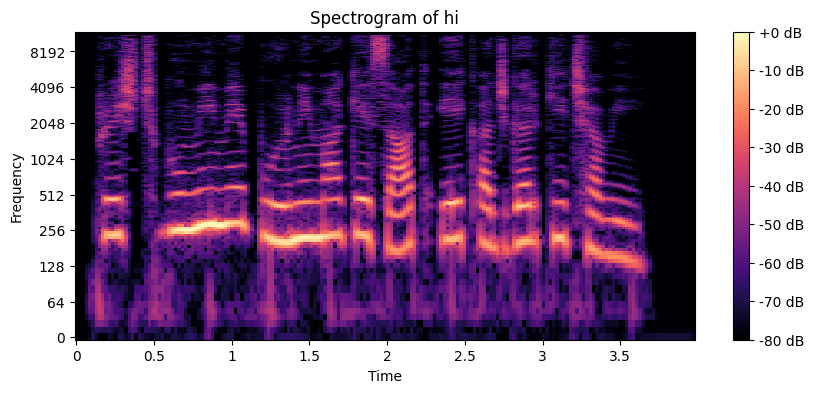

Playing mr_gTTS_translation.mp3


Plotting spectrogram for mr_gTTS_translation.mp3


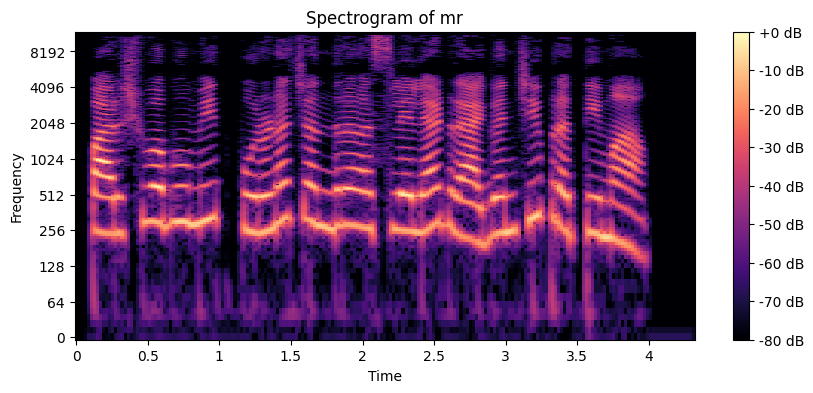

Playing gu_gTTS_translation.mp3


Plotting spectrogram for gu_gTTS_translation.mp3


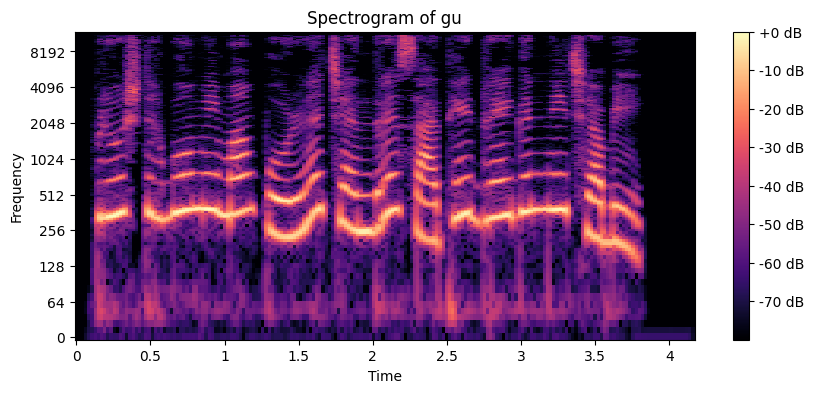

In [22]:
def play_audio(file_path):
    # Loading the audio file
    y, sr = librosa.load(file_path, sr=None)
    # Display audio player for the file
    display(Audio(data=y, rate=sr))

def plot_spectrogram(file_path):
    y, sr = librosa.load(file_path, sr=None)
    # Computing the spectrogram
    D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
    # Plot the spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram of {file_path[:2]}')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.show()

audio_files = [
    "hi_gTTS_translation.mp3",
    "mr_gTTS_translation.mp3",
    "gu_gTTS_translation.mp3"
]
for file_path in audio_files:
    print(f"Playing {file_path}")
    play_audio(file_path)
    print(f"Plotting spectrogram for {file_path}")
    plot_spectrogram(file_path)


### **Facebook's MMS-TTS' Inference**

 - But it does not make sense use to completely depend on API while some State-Of-the-Art models for TTS are available (given that they may not perform equally well on regional Indic languages.)
 - Therefore to present working demonstartion of TTS synthesis using some models I found exploring, one of the them which provided decent results on Hindi language was **`Facebook's Vits MMS model for tts`** which claims to provide TTS synthesis over 1000 languages.
 - This  model is a part of Facebook's Massively Multilingual Speech project, aiming to provide speech technology across a diverse range of languages.

In [31]:
import torch
from transformers import VitsTokenizer, VitsModel, set_seed
from IPython.display import Audio, display
import soundfile as sf

# Seperate models for Hindi, Marathi and Gujarati
models = {
    'hin_Deva': {
        'model_name': "facebook/mms-tts-hin",
        'output_suffix': 'Hindi'
    },
    'mar_Deva': {
        'model_name': "facebook/mms-tts-mar",
        'output_suffix': 'Marathi'
    },
    'guj_Gujr':{
        'model_name': "facebook/mms-tts-guj",
        'output_suffix': 'Guju'
    }
}

def generate_audio_fbmms(text, model_name, output_file):

    tokenizer = VitsTokenizer.from_pretrained(model_name)
    model = VitsModel.from_pretrained(model_name)

    inputs = tokenizer(text=text, return_tensors="pt")

    # Set seed for deterministic results
    set_seed(555)

    with torch.no_grad():
        outputs = model(**inputs)

    waveform = outputs.waveform[0].cpu().numpy()
    sf.write(output_file, waveform, samplerate=model.config.sampling_rate)

    return Audio(output_file, rate=model.config.sampling_rate)

audio_files = {}
for lang, text in translations.items():
    if lang in models:
        model_info = models[lang]
        model_name = model_info['model_name']
        output_file = f"{lang}_MMS_TTS.{model_info['output_suffix']}.wav"

        audio = generate_audio_fbmms(text, model_name, output_file)
        audio_files[lang] = audio

for lang, audio in audio_files.items():
    print(f"Playing {lang} audio:")
    display(audio)


Some weights of the model checkpoint at facebook/mms-tts-hin were not used when initializing VitsModel: ['flow.flows.0.wavenet.in_layers.0.weight_g', 'flow.flows.0.wavenet.in_layers.0.weight_v', 'flow.flows.0.wavenet.in_layers.1.weight_g', 'flow.flows.0.wavenet.in_layers.1.weight_v', 'flow.flows.0.wavenet.in_layers.2.weight_g', 'flow.flows.0.wavenet.in_layers.2.weight_v', 'flow.flows.0.wavenet.in_layers.3.weight_g', 'flow.flows.0.wavenet.in_layers.3.weight_v', 'flow.flows.0.wavenet.res_skip_layers.0.weight_g', 'flow.flows.0.wavenet.res_skip_layers.0.weight_v', 'flow.flows.0.wavenet.res_skip_layers.1.weight_g', 'flow.flows.0.wavenet.res_skip_layers.1.weight_v', 'flow.flows.0.wavenet.res_skip_layers.2.weight_g', 'flow.flows.0.wavenet.res_skip_layers.2.weight_v', 'flow.flows.0.wavenet.res_skip_layers.3.weight_g', 'flow.flows.0.wavenet.res_skip_layers.3.weight_v', 'flow.flows.1.wavenet.in_layers.0.weight_g', 'flow.flows.1.wavenet.in_layers.0.weight_v', 'flow.flows.1.wavenet.in_layers.1.wei

Playing hin_Deva audio:


Playing mar_Deva audio:


Playing guj_Gujr audio:


## **`Try it yourself`**:
 Upload any image (**standard**) that BLIP pre-trained on MS COCO would be able to detect and generate captions for.

<!-- And by standard what I meant is that image should be that model would be trained / familiar with and not something like alien eatng pudding with donald trump -->

In [36]:
# Pipeline
def pipeline(image_path, target_languages, models):
    # Stage 1:Generate Caption
    caption = generate_caption(image_path)
    print(f"Generated Caption: {caption}")

    # Stage 2: Translate Caption
    translations = translate_caption(caption, target_languages)

    # Stage 3: Generate Audio for Translations
    audio_files = {}
    for lang, text in translations.items():
        if lang in models:
            model_info = models[lang]
            model_name = model_info['model_name']
            output_file = f"{lang}_MMS_TTS.{model_info['output_suffix']}.wav"

            audio = generate_audio_fbmms(text, model_name, output_file)
            audio_files[lang] = audio

    for lang, audio in audio_files.items():
        print(f"Playing {lang} audio:")
        display(audio)

# Give it a try by proving path to your image
image_path = "/content/Untitled.jpg"
target_languages = ["hin_Deva", "mar_Deva", "guj_Gujr"]  # Hindi, Marathi, Gujarati

# Update models for generating audio in case the language support u r expecting is not among [Hindi, Marathi, Gujarati]
models = {
    "hin_Deva": {"model_name": "facebook/mms-tts-hin", "output_suffix": "hin"},
    "mar_Deva": {"model_name": "facebook/mms-tts-mar", "output_suffix": "mar"},
    "guj_Gujr": {"model_name": "facebook/mms-tts-guj", "output_suffix": "guj"}
}

pipeline(image_path, target_languages, models)

Generated Caption: image of a soccer player kicking a soccer ball on a field


Some weights of the model checkpoint at facebook/mms-tts-hin were not used when initializing VitsModel: ['flow.flows.0.wavenet.in_layers.0.weight_g', 'flow.flows.0.wavenet.in_layers.0.weight_v', 'flow.flows.0.wavenet.in_layers.1.weight_g', 'flow.flows.0.wavenet.in_layers.1.weight_v', 'flow.flows.0.wavenet.in_layers.2.weight_g', 'flow.flows.0.wavenet.in_layers.2.weight_v', 'flow.flows.0.wavenet.in_layers.3.weight_g', 'flow.flows.0.wavenet.in_layers.3.weight_v', 'flow.flows.0.wavenet.res_skip_layers.0.weight_g', 'flow.flows.0.wavenet.res_skip_layers.0.weight_v', 'flow.flows.0.wavenet.res_skip_layers.1.weight_g', 'flow.flows.0.wavenet.res_skip_layers.1.weight_v', 'flow.flows.0.wavenet.res_skip_layers.2.weight_g', 'flow.flows.0.wavenet.res_skip_layers.2.weight_v', 'flow.flows.0.wavenet.res_skip_layers.3.weight_g', 'flow.flows.0.wavenet.res_skip_layers.3.weight_v', 'flow.flows.1.wavenet.in_layers.0.weight_g', 'flow.flows.1.wavenet.in_layers.0.weight_v', 'flow.flows.1.wavenet.in_layers.1.wei

Playing hin_Deva audio:


Playing mar_Deva audio:


Playing guj_Gujr audio:


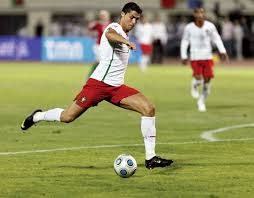

## `Workflow summary :`



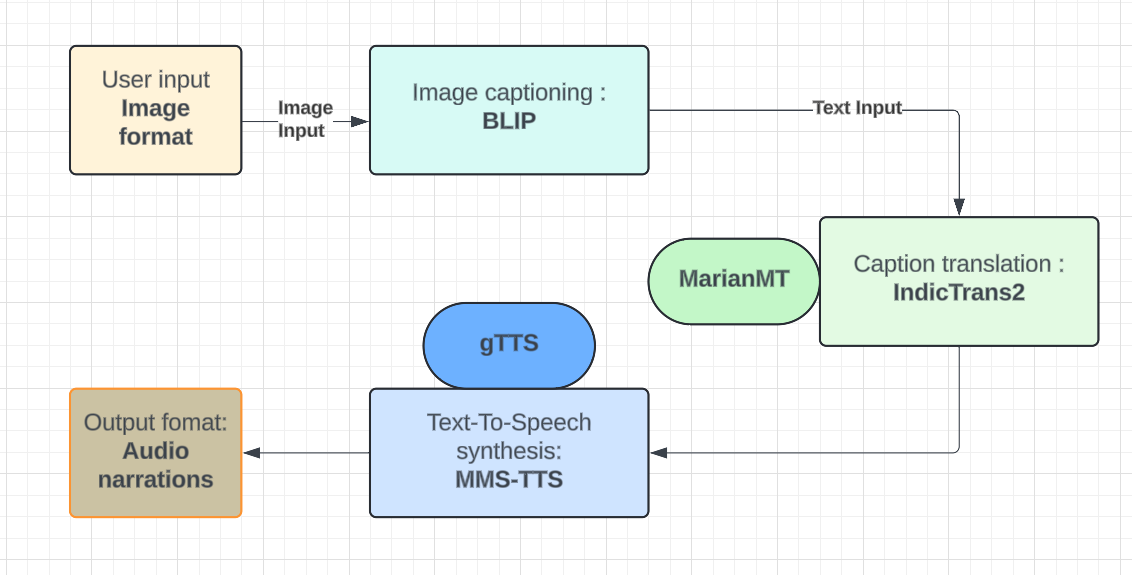


# **`Conclusion`**

This project successfully developed a multilingual assistive model to aid visually impaired users by generating image descriptions in multiple Indian languages and converting them into audio. Key achievements include:

- **Image Captioning**: Using the `Salesforce/blip-image-captioning-large` model to describe images accurately.
- **Multilingual Translation**: Translating captions into various Indic languages using `ai4bharat/indictrans2-en-indic-1B`.
- **Text-to-Speech (TTS)**: Generating audio for each translated caption with TTS models.


# **`References for models and API used`**:

- [BLIP Model](https://huggingface.co/Salesforce/blip-image-captioning-large)
- [MarinaMT](https://huggingface.co/docs/transformers/en/model_doc/marian#transformers.MarianMTModel)
- [IndicTrans2ToolKit Updated GitHub](https://github.com/VarunGumma/IndicTransToolkit)
- [Facebook's MMS TTS](https://huggingface.co/docs/transformers/main/en/model_doc/mms)
- [IndicTrans2 HF](https://huggingface.co/ai4bharat/indictrans2-indic-en-1B)
- [gTTS](https://gtts.readthedocs.io/en/latest/)

